In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
'''
Article: https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2767980
Data Source: https://data.cdc.gov/resource/muzy-jte6
'''

import covid_19_shared


# reported_data = pd.read_csv('cv-dev-usa.csv', parse_dates=["Date"], index_col="Date").dropna()
reported_data = covid_19_shared.loadJHUData("US", True)

# Read from URL
url="https://data.cdc.gov/api/views/muzy-jte6/rows.csv"
df = pd.read_csv(url)
df.tail(5)


,Jurisdiction of Occurrence,MMWR Year,MMWR Week,Week Ending Date,All Cause,Natural Cause,Septicemia (A40-A41),Malignant neoplasms (C00-C97),Diabetes mellitus (E10-E14),Alzheimer disease (G30),...,flag_alz,flag_inflpn,flag_clrd,flag_otherresp,flag_nephr,flag_otherunk,flag_hd,flag_stroke,flag_cov19mcod,flag_cov19ucod
4798,United States,2020,33,2020-08-15,59945.0,56312.0,699.0,11230.0,1738.0,2424.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4799,United States,2020,34,2020-08-22,56955.0,53592.0,662.0,10736.0,1685.0,2411.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4800,United States,2020,35,2020-08-29,53381.0,50396.0,631.0,10494.0,1557.0,2209.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4801,United States,2020,36,2020-09-05,48312.0,45715.0,553.0,9619.0,1368.0,2145.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4802,United States,2020,37,2020-09-12,39558.0,37861.0,427.0,8319.0,1132.0,1750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Filter USA only
is_us=df["Jurisdiction of Occurrence"] == "United States"
df2 = df[is_us]

# df.index = range(0, df.shape[0]) # df.shape[0] gives number of row count
# print(df)

# Drop Unused Columns:
columns_to_delete = [0]
for col in range(5, len(df2.columns)):
    columns_to_delete.append(col)
df2 = df2.drop(df2.columns[columns_to_delete], axis=1) 


# Rename columns
df2 = df2.rename({"MMWR Year": 'Year'
           , "MMWR Week": 'Week'
           , "All Cause": 'NumDeaths'
           , "Week Ending Date" : "WkDt"
        }, axis='columns')
df2




,Year,Week,WkDt,NumDeaths
4714,2019,1,2019-01-05,58463.0
4715,2019,2,2019-01-12,58514.0
4716,2019,3,2019-01-19,58354.0
4717,2019,4,2019-01-26,58034.0
4718,2019,5,2019-02-02,58289.0
...,...,...,...,...
4798,2020,33,2020-08-15,59945.0
4799,2020,34,2020-08-22,56955.0
4800,2020,35,2020-08-29,53381.0
4801,2020,36,2020-09-05,48312.0


In [3]:
def get_year(year : int):
    is_yr = df2.Year == year
    return df2[is_yr]


years = [2019, 2020]
data_by_year = dict()
for year in years:
    data_by_year[year] = get_year(year)
    data_by_year[year].set_index('Week', inplace=True)



               Diff
WkDt               
2020-08-15   8812.0
2020-08-22   5806.0
2020-08-29   2078.0
2020-09-05  -3648.0
2020-09-12 -12200.0


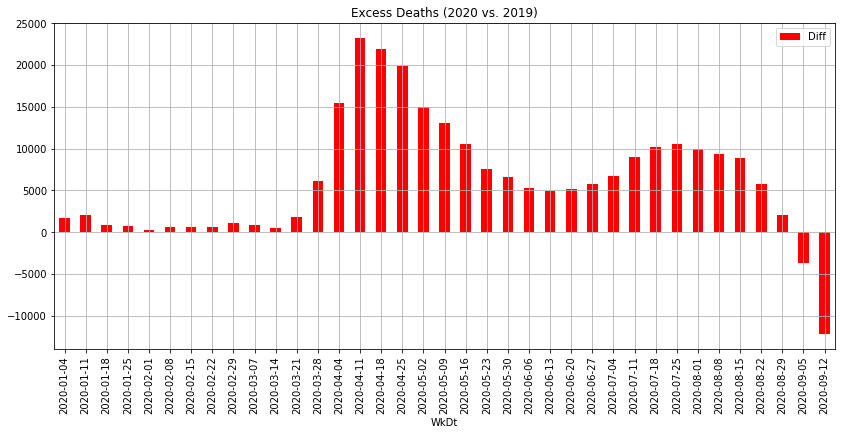

In [4]:
df_2019 = data_by_year[2019]
df_2020 = data_by_year[2020]
diff = (df_2020.NumDeaths - df_2019.NumDeaths).dropna().array

df = df_2020.set_index('WkDt')
df.loc[:, 'Diff'] = diff

excess_deaths_df = df.drop(df.columns[[0, 1]], axis=1)
# df = df[:-1]
print(excess_deaths_df.tail(5))
excess_deaths_df.plot(kind='bar'
        , figsize=(14, 6)
        , legend=["Excess Deaths"]
        , grid = True
        , color = ['red']
        , title = "Excess Deaths (2020 vs. 2019)"
        )


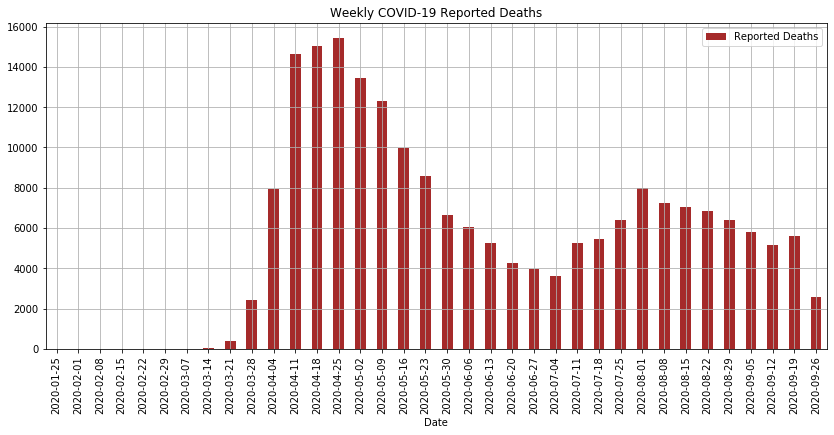

In [5]:
reported_covid_deaths = (reported_data.Dead - reported_data.Dead.shift(1)).dropna().resample('1W-SAT').sum()
reported_covid_deaths.index = reported_covid_deaths.index.strftime('%Y-%m-%d')
reported_covid_deaths.plot(
        kind='bar'
        , figsize=(14, 6)
        , legend=True
        , label="Reported Deaths"
        , grid = True
        , align = 'center'
        , color = ['brown']
        , title = "Weekly COVID-19 Reported Deaths"
        )


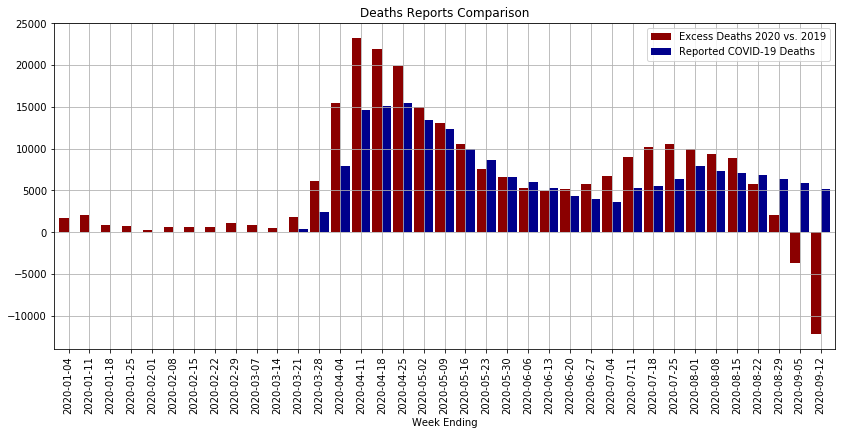

In [9]:
df = pd.DataFrame({
                    "Excess Deaths 2020 vs. 2019": excess_deaths_df.Diff
                    , "Reported COVID-19 Deaths" : reported_covid_deaths 
                  }
                  , index=excess_deaths_df.Diff.index)
df.index.names = ["Week Ending"]
df.plot(kind='bar'
        , stacked=False
        , figsize=(14, 6)
        , legend=True
        , grid = True
        , width = 0.9
        , color = ['darkred', 'darkblue']
        , title = "Deaths Reports Comparison"
        )
# plt.gcf().autofmt_xdate()
plt.show()
